In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
import os
import json
import time
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Load Data

In [2]:
IMAGE_DIR = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/"
STYLE_DIR = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles/"

In [4]:
df = pd.read_csv("/kaggle/input/clean-data/Cleaned_Data.csv")
df.head()

,id,productDisplayName,brandName,gender,baseColour,season,year,usage,masterCategory,subCategory,articleType,imageURL,image_path
0,1566,Artengo Men Black Cap,Artengo,Men,Black,Summer,2011,Sports,Accessories,Headwear,Caps,http://assets.myntassets.com/v1/images/style/p...,1566.jpg
1,39342,Fila Men Zoom Black Shoes,FILA,Men,Black,Summer,2012,Casual,Footwear,Shoes,Casual Shoes,http://assets.myntassets.com/v1/images/style/p...,39342.jpg
2,13182,FILA Men Dls Maxim Black Sports Shoes,FILA,Men,Black,Fall,2011,Sports,Footwear,Shoes,Sports Shoes,http://assets.myntassets.com/v1/images/style/p...,13182.jpg
3,21762,Fossil Men Mead Black Belt,Fossil,Men,Black,Fall,2011,Casual,Accessories,Belts,Belts,http://assets.myntassets.com/v1/images/style/p...,21762.jpg
4,48692,Lucera Women Silver Earrings,Lucera,Women,Silver,Summer,2012,Casual,Accessories,Jewellery,Earrings,http://assets.myntassets.com/v1/images/style/p...,48692.jpg


In [5]:
df.isnull().sum()

id                    0
productDisplayName    0
brandName             0
gender                0
baseColour            0
season                0
year                  0
usage                 0
masterCategory        0
subCategory           0
articleType           0
imageURL              0
image_path            0
dtype: int64

# 2. Preprocess Images for Model Training


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in ["baseColour", "articleType", "season", "gender"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le  # Store encoders for inference

In [8]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Standard normalization values for ImageNet. 
])

In [ ]:
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Custom Dataset
class FashionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.image_dir, f"{row['image_path']}")
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        labels = torch.tensor([
            row["baseColour"], 
            row["articleType"], 
            row["season"], 
            row["gender"]], dtype=torch.long)
        
        return image, labels

In [10]:
# Create dataset and dataloader
dataset = FashionDataset(df, IMAGE_DIR, transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

In [11]:
image, labels = dataset[0]

print("Type of labels:", type(labels))
print("Labels shape:", labels.shape)
print("Labels:", labels)

Type of labels: <class 'torch.Tensor'>
Labels shape: torch.Size([4])
Labels: tensor([ 1, 18,  2,  2])


In [12]:
for images, labels in dataloader:
    print(images.shape)
    print(labels)
    break  # Just to check one batch

torch.Size([64, 3, 224, 224])
tensor([[  2,  17,   2,   1],
        [  1, 109,   0,   4],
        [ 33,  48,   4,   4],
        [ 11,  91,   1,   4],
        [ 33,   2,   0,   3],
        [ 19, 104,   2,   2],
        [ 12, 133,   2,   2],
        [ 33, 126,   2,   1],
        [ 31,  66,   2,   4],
        [  1, 133,   2,   4],
        [  4,  48,   2,   4],
        [ 12,  63,   2,   4],
        [  2, 112,   0,   2],
        [ 12,  27,   1,   4],
        [ 33,  31,   0,   4],
        [  1, 117,   2,   2],
        [ 11,  22,   4,   4],
        [ 31, 133,   2,   4],
        [  1,  48,   2,   4],
        [ 45,  63,   2,   4],
        [  4, 131,   0,   2],
        [  1, 112,   0,   2],
        [ 13, 112,   0,   4],
        [ 45, 112,   2,   4],
        [ 33, 133,   2,   2],
        [  1,  48,   2,   4],
        [  1, 104,   0,   2],
        [  4, 100,   0,   2],
        [ 13,  55,   0,   2],
        [  2,  56,   2,   2],
        [ 33,  63,   2,   2],
        [ 45,  19,   0,   2],
        [ 

In [13]:
# Get number of classes
num_colors = len(label_encoders["baseColour"].classes_)
print(f"Numbers of Colors : {num_colors}")

num_types = len(label_encoders["articleType"].classes_)
print(f"Numbers of Types : {num_types}")

num_seasons = len(label_encoders["season"].classes_)
print(f"Numbers of Seasons : {num_seasons}")

num_genders = len(label_encoders["gender"].classes_)
print(f"Numbers of Gender : {num_genders}")

Numbers of Colors : 47
Numbers of Types : 142
Numbers of Seasons : 5
Numbers of Gender : 5


# 4. Multi-Output CNN Model

In [ ]:
import torch.nn as nn
import torchvision.models as models

class FashionClassifier(nn.Module):
    def __init__(self, num_colors, num_types, num_seasons, num_genders):
        super(FashionClassifier, self).__init__()
        
        # Load pre-trained Efficientnet_V2_S
        self.backbone = models.efficientnet_v2_s(weights=True)
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()
        
        # Classification heads
        self.color_head = nn.Linear(in_features, num_colors)
        self.type_head = nn.Linear(in_features, num_types)
        self.season_head = nn.Linear(in_features, num_seasons)
        self.gender_head = nn.Linear(in_features, num_genders)
    
    def forward(self, x):
        features = self.backbone(x)
        
        color_out = self.color_head(features)
        type_out = self.type_head(features)
        season_out = self.season_head(features)
        gender_out = self.gender_head(features)
        
        return color_out, type_out, season_out, gender_out


# Initialize model
model = FashionClassifier(num_colors, num_types, num_seasons, num_genders)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_S_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 181MB/s] 


# 5. Train the Model

In [15]:
import time
import torch.optim as optim
from torch.nn.functional import cross_entropy

# GPU
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(num_gpus)

if num_gpus > 1:
    model = torch.nn.DataParallel(model)

model.to(device)

2


DataParallel(
  (module): FashionClassifier(
    (backbone): EfficientNet(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): Sequential(
          (0): FusedMBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
                (2): SiLU(inplace=True)
              )
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): FusedMBConv(
            (block): Sequential(
              (0): Conv2dNormActivation(
                (0): Conv2d(24, 24, kernel_size=(3, 3

In [16]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:

from tqdm import tqdm

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")  
    model.train()
    running_loss = 0.0
    correct_preds = [0, 0, 0, 0]  # Track correct predictions for each task
    total_samples = 0
    
    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as t:
        start_time = time.time()
        
        for images, labels in t:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass
            color_out, type_out, season_out, gender_out = model(images)
            
            # Compute loss
            loss_color = cross_entropy(color_out, labels[:, 0])  
            loss_type = cross_entropy(type_out, labels[:, 1])  
            loss_season = cross_entropy(season_out, labels[:, 2])  
            loss_gender = cross_entropy(gender_out, labels[:, 3])  
            total_loss = loss_color + loss_type + loss_season + loss_gender
            
            # Backpropagation
            total_loss.backward()
            optimizer.step()
            
            running_loss += total_loss.item()
            total_samples += labels.size(0)
            
            # Compute accuracy for each classification task
            correct_preds[0] += (color_out.argmax(dim=1) == labels[:, 0]).sum().item()
            correct_preds[1] += (type_out.argmax(dim=1) == labels[:, 1]).sum().item()
            correct_preds[2] += (season_out.argmax(dim=1) == labels[:, 2]).sum().item()
            correct_preds[3] += (gender_out.argmax(dim=1) == labels[:, 3]).sum().item()
            
            # Update progress bar with loss
            t.set_postfix(loss=total_loss.item())
        
        end_time = time.time()
        epoch_time = end_time - start_time
        
        # Compute overall accuracy for each classification task
        color_acc = correct_preds[0] / total_samples * 100
        type_acc = correct_preds[1] / total_samples * 100
        season_acc = correct_preds[2] / total_samples * 100
        gender_acc = correct_preds[3] / total_samples * 100
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader):.4f}, Time: {epoch_time:.2f}s")
        print(f"Accuracy - Color: {color_acc:.2f}%, Type: {type_acc:.2f}%, Season: {season_acc:.2f}%, Gender: {gender_acc:.2f}%\n")


Epoch 1/10


Epoch 1/10: 100%|██████████| 695/695 [17:21<00:00,  1.50s/batch, loss=2.53]


Epoch [1/10], Loss: 3.2052, Time: 1041.59s
Accuracy - Color: 60.78%, Type: 79.19%, Season: 68.61%, Gender: 87.62%

Epoch 2/10


Epoch 2/10: 100%|██████████| 695/695 [18:32<00:00,  1.60s/batch, loss=2.5] 


Epoch [2/10], Loss: 2.3211, Time: 1112.74s
Accuracy - Color: 68.09%, Type: 86.79%, Season: 74.74%, Gender: 91.44%

Epoch 3/10


Epoch 3/10: 100%|██████████| 695/695 [18:34<00:00,  1.60s/batch, loss=2.47]


Epoch [3/10], Loss: 2.0110, Time: 1114.07s
Accuracy - Color: 70.88%, Type: 89.38%, Season: 77.83%, Gender: 92.92%

Epoch 4/10


Epoch 4/10: 100%|██████████| 695/695 [18:30<00:00,  1.60s/batch, loss=2.44]


Epoch [4/10], Loss: 1.7742, Time: 1110.74s
Accuracy - Color: 73.49%, Type: 90.98%, Season: 80.24%, Gender: 93.86%

Epoch 5/10


Epoch 5/10: 100%|██████████| 695/695 [18:27<00:00,  1.59s/batch, loss=1.63]


Epoch [5/10], Loss: 1.5495, Time: 1107.25s
Accuracy - Color: 76.11%, Type: 92.54%, Season: 82.59%, Gender: 94.86%

Epoch 6/10


Epoch 6/10: 100%|██████████| 695/695 [18:20<00:00,  1.58s/batch, loss=1.95] 


Epoch [6/10], Loss: 1.3409, Time: 1100.85s
Accuracy - Color: 78.54%, Type: 93.79%, Season: 85.04%, Gender: 95.76%

Epoch 7/10


Epoch 7/10: 100%|██████████| 695/695 [18:25<00:00,  1.59s/batch, loss=1.22] 


Epoch [7/10], Loss: 1.1588, Time: 1105.57s
Accuracy - Color: 81.13%, Type: 94.74%, Season: 87.01%, Gender: 96.28%

Epoch 8/10


Epoch 8/10: 100%|██████████| 695/695 [18:28<00:00,  1.59s/batch, loss=1.22] 


Epoch [8/10], Loss: 0.9671, Time: 1108.26s
Accuracy - Color: 83.81%, Type: 95.70%, Season: 89.34%, Gender: 96.94%

Epoch 9/10


Epoch 9/10: 100%|██████████| 695/695 [18:29<00:00,  1.60s/batch, loss=1.31] 


Epoch [9/10], Loss: 0.8069, Time: 1109.57s
Accuracy - Color: 86.45%, Type: 96.62%, Season: 91.25%, Gender: 97.39%

Epoch 10/10


Epoch 10/10: 100%|██████████| 695/695 [18:24<00:00,  1.59s/batch, loss=1.45] 

Epoch [10/10], Loss: 0.6985, Time: 1104.96s
Accuracy - Color: 88.01%, Type: 97.06%, Season: 92.50%, Gender: 97.72%



# 6. Save Model

In [19]:
# Save model
torch.save(model.state_dict(), "fashion_classifier.pth")

# 7. Load Model on GPUs

In [ ]:
model = FashionClassifier(num_colors, num_types, num_seasons, num_genders)

# If multiple GPUs were used in training, wrap with DataParallel
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

# Load only weights into the model
state_dict = torch.load(
    "/kaggle/input/fashion_classifier/pytorch/default/1/fashion_classifier.pth", 
    map_location="cuda"
)

model.load_state_dict(state_dict)  # Correct way to load state_dict
model.to("cuda")
model.eval()

# 8. Model Inference

In [ ]:
def predict(image_path, model, transform, label_encoders):
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to("cuda")
    
    with torch.no_grad():
        color_out, type_out, season_out, gender_out = model(input_tensor)
    
    color_pred = torch.argmax(color_out, dim=1).item()
    type_pred = torch.argmax(type_out, dim=1).item()
    season_pred = torch.argmax(season_out, dim=1).item()
    gender_pred = torch.argmax(gender_out, dim=1).item()
    
    predictions = {
        "color": label_encoders["baseColour"].inverse_transform([color_pred])[0],
        "product_type": label_encoders["articleType"].inverse_transform([type_pred])[0],
        "season": label_encoders["season"].inverse_transform([season_pred])[0],
        "gender": label_encoders["gender"].inverse_transform([gender_pred])[0]
    }
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    title_text = "\n".join([f"{key}: {value}" for key, value in predictions.items()])
    plt.title(title_text, fontsize=12, color="black")
    plt.show()
    
    return predictions

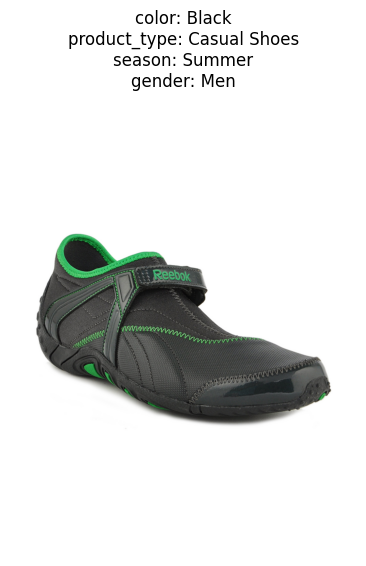

{'color': 'Black', 'product_type': 'Casual Shoes', 'season': 'Summer', 'gender': 'Men'}


In [29]:
image_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/10101.jpg"
prediction = predict(image_path, model, transform, label_encoders)
print(prediction)

## Testpoint

In [31]:
import requests

url = "http://127.0.0.1:5000/predict"
img_path = "D:/Project/fashion-image-classifier/images/images2.jpg"

file = {"file": open(img_path, "rb")}
response = requests.post(url, files=file)

print(response.text)

# print(response.json())

{
  "Color": "Grey",
  "Gender": "Men",
  "Product Type": "Shirts",
  "Season": "Summer"
}

